# Chest x-ray diagnosis using deep learning models
## The model structure to study: ResNet50
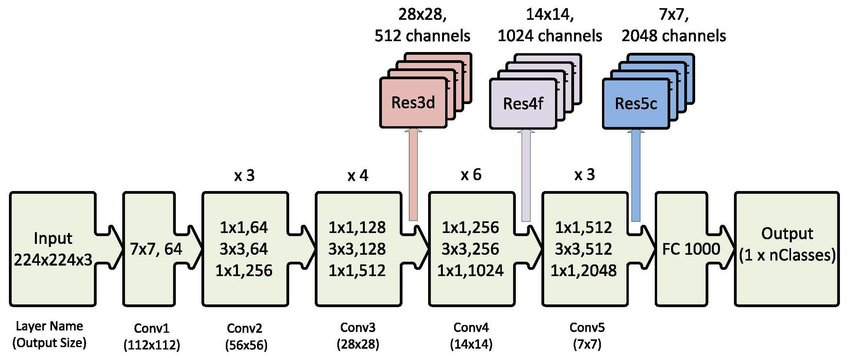


## Data Source: Stanford ChexPert Data - [CheXpert-v1.0-small]( https://stanfordmlgroup.github.io/competitions/chexpert/)

In [1]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.applications import  ResNet50#ResNeXt101 #ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#import pydotplus
#import pydot as pyd
#from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


## data preprocessing
- Only frontal images are considered in my project. I remove latteral images.
- Only x-ray images considered as input to the model. "Sex", "Age", "Frontal/Lateral", and "AP/PA" features were removed from training data
- Combined the downloaded validation data with train data as the validation data from the download link is very small comparing to the training data(200 images versus almost 200K images in training data)


In [2]:
dtrain=pd.read_csv("CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)
# import valid data info from valid.csv
dnew=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
#pre-process data: drop selected features - only images as inputs
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
print(dtrain.shape)
dtrain.describe().transpose()

(191229, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,191229.0,0.088899,0.284598,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,191229.0,-0.005198,0.319927,-1.0,0.0,0.0,0.0,1.0
Cardiomegaly,191229.0,0.087560,0.387350,-1.0,0.0,0.0,0.0,1.0
Lung Opacity,191229.0,0.470101,0.543553,-1.0,0.0,0.0,1.0,1.0
Lung Lesion,191229.0,0.031026,0.204087,-1.0,0.0,0.0,0.0,1.0
Edema,191229.0,0.198186,0.531517,-1.0,0.0,0.0,1.0,1.0
Consolidation,191229.0,-0.059437,0.438206,-1.0,0.0,0.0,0.0,1.0
Pneumonia,191229.0,-0.059081,0.323371,-1.0,0.0,0.0,0.0,1.0
Atelectasis,191229.0,-0.000356,0.558545,-1.0,0.0,0.0,0.0,1.0
Pneumothorax,191229.0,0.078398,0.317135,-1.0,0.0,0.0,0.0,1.0


 - Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were consdiered as positive (replaced -1 by 1)
 - Data statistics show Lung Opacity, Edema, Atelectasis, Pleural Effusion and Support Devices have more balanced positive versus negative cases. The resut of observations have less than 25% of positive observations

In [3]:
# dealing with uncertanty (-1) values
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No Finding,191229.0,0.088899,0.284598,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,191229.0,0.102380,0.303148,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,191229.0,0.157706,0.364466,0.0,0.0,0.0,0.0,1.0
Lung Opacity,191229.0,0.516444,0.499731,0.0,0.0,1.0,1.0,1.0
Lung Lesion,191229.0,0.042614,0.201985,0.0,0.0,0.0,0.0,1.0
Edema,191229.0,0.321787,0.467163,0.0,0.0,0.0,1.0,1.0
Consolidation,191229.0,0.195556,0.396629,0.0,0.0,0.0,0.0,1.0
Pneumonia,191229.0,0.108059,0.310456,0.0,0.0,0.0,0.0,1.0
Atelectasis,191229.0,0.311972,0.463299,0.0,0.0,0.0,1.0,1.0
Pneumothorax,191229.0,0.106720,0.308758,0.0,0.0,0.0,0.0,1.0


- The combined data were split into train, validation, and test sets. 10% of data were used for validation and test data. 

In [4]:
### split data into train/valid/test
dtrain = dtrain.sample(frac=1)
dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size
dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

In [5]:
print(dtr.shape)
#dtr.describe().transpose()

(152984, 15)


In [6]:
print(dv.shape)
#dv.describe().transpose()

(19124, 15)


In [7]:
print(dte.shape)
#dte.describe().transpose()

(19123, 15)


 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

In [8]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
#target_size = (299,299)
#target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:15]), class_mode="other", target_size=target_size, batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None, x_col="Path", y_col=list(dv.columns[1:15]), class_mode="other", target_size=target_size, batch_size=32)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None, x_col="Path", y_col=list(dte.columns[1:15]), class_mode="other", target_size=target_size, shuffle = False, batch_size=1)


Found 152984 images.
Found 19124 images.
Found 19123 images.


- A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify ResNet50 architecture for our application. The weights are initialized with a network weights tuned for imagenet data. <font color=blue>All weights are tuned.</font>
- loss function is defined as binary cross entropy loss. 
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False

In [9]:
### model architecture design/selection
# create the base pre-trained model
base_model = ResNet50(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(14, activation='sigmoid')(x)

# this is the model we will train
model_F = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model_F.summary())

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Fit the model on aws with epochs = 3. Model is saved after fiting is done.

In [30]:
### fit model 
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)
# save model
model_F.save("model_ResNet50_Full.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
4780/4780 [==============================] - 4295s 898ms/step - loss: 0.3599 - acc: 0.8423 - val_loss: 0.4073 - val_acc: 0.8252
Epoch 2/3
4780/4780 [==============================] - 4278s 895ms/step - loss: 0.3391 - acc: 0.8526 - val_loss: 0.3521 - val_acc: 0.8476
Epoch 3/3
4780/4780 [==============================] - 4277s 895ms/step - loss: 0.3234 - acc: 0.8597 - val_loss: 0.3511 - val_acc: 0.8476


load the trained model here.

In [31]:
model_F = load_model('model_ResNet50_Full.h5')
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

- Precision, recall, and f1-score are calculated on train data. **The threshold for positive is set to 0.5**
- The results indicate changing model structure does not improve F1 score. As this will show later, the issue is fixed with balancing class observations. 

In [32]:
### prediction and performance assessment
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.67      0.12      0.21      1719
Enlarged Cardiomediastinum       0.39      0.02      0.03      1897
              Cardiomegaly       0.55      0.51      0.53      2976
              Lung Opacity       0.64      0.77      0.70      9903
               Lung Lesion       0.39      0.06      0.11       769
                     Edema       0.66      0.56      0.61      6135
             Consolidation       0.42      0.02      0.04      3762
                 Pneumonia       0.61      0.01      0.02      2063
               Atelectasis       0.49      0.36      0.41      5961
              Pneumothorax       0.67      0.24      0.35      2047
          Pleural Effusion       0.71      0.86      0.78      8679
             Pleural Other       0.00      0.00      0.00       455
                  Fracture       0.45      0.01      0.01       814
           Support Devices       0.80      0.86

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Calculate accuracy on test data

In [33]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.35149853334282005
Test accuracy: 0.846975588065426
